In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns;

sns.set()

In [ ]:
"""
Implement VaR backtesting by computing 99%/10day Value at Risk using the rolling window of 21
returns to compute σ.

99%/10day Value at Risk for an investment in the market index on the rolling basis
VaR10D;t = Factor × σt × p10
1. determine factor
2. create 10 day log return column
x. create column with 10 day returns
3. calculate rolling standard deviation over log-returns for observations 1 −21; 2−22; etc
4. Compute VaR for each day t, after the initial perio
"""


In [3]:
filepath = Path(r'input/prices.csv')
df = pd.read_csv(filepath)

df.rename(columns={'open' : 'price'}, inplace=True)

df = df[['date', 'price']]
df.columns = ['date', 'price']

In [ ]:
df['log_return_1d'].shift(1)

0            NaN
1            NaN
2      -0.003817
3      -0.023570
4      -0.011726
          ...   
1235   -0.002062
1236   -0.015100
1237   -0.000524
1238   -0.013567
1239    0.001396
Name: log_return_1d, Length: 1240, dtype: float64

In [ ]:
df = df[['date', 'price']]
df.columns = ['date', 'price']

# calculate variables
df['log_return_1d'] = np.log(1 + df.price.pct_change(1)).astype(float)
df['log_return_shifted'] = df['log_return_1d'].shift(1)
df['log_return_10d'] = np.log(1 + df.price.pct_change(10))
df['20d_rolling_std'] = df['log_return_1d'].rolling(21).std()
df['VaR'] = -(df['20d_rolling_std'] * 2.33 * np.sqrt(10))
df['breach'] = np.where(df['VaR'] > df['log_return_10d'], 1, 0)
df['consecutive_breach'] = np.where((df['breach'].shift(1) == 1) & (df['breach'] == 1), 1, 0)

In [5]:
# 3.A.1 report the percentage of VaR breaches
pct_breach = (len(df[df['breach'] == 1]) / len(df)) * 100
print('The number of VaR breaches is {}. This is {} percent'.format(len(df[df['breach'] == 1]), pct_breach))

# 3.A.2: report the number of consecutive breaches
print('The number of consecutive breaches is {}'.format(df['consecutive_breach'].sum()))

The number of VaR breaches is 4. This is 0.3225806451612903 percent
The number of consecutive breaches is 2


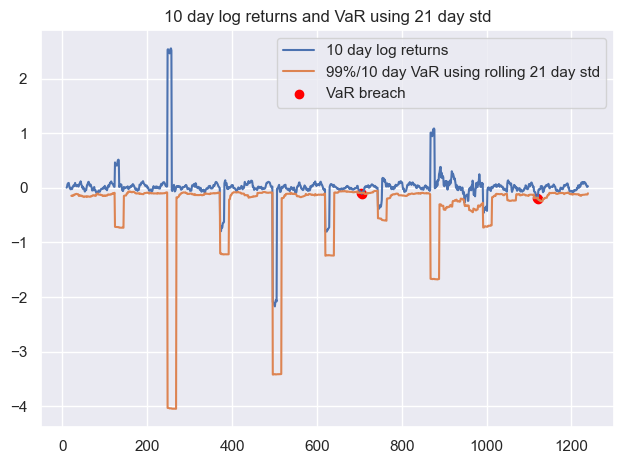

In [6]:
# 3.A.3: Provide a plot which clearly identifies breaches
plt.plot(df['log_return_10d'], label='10 day log returns')
plt.plot(df['VaR'], label='99%/10 day VaR using rolling 21 day std')
plt.scatter(df[df['breach'] == 1].index, df[df['breach'] == 1]['log_return_10d'], color='red', label='VaR breach')
plt.legend()
plt.title('10 day log returns and VaR using 21 day std')
plt.grid(True)
plt.tight_layout()
plt.show()

In [7]:
ewma_lambda = 0.72
ewma_lambda_21d_series = np.array([(1 - ewma_lambda) * (ewma_lambda ** x) for x in range(21, 0, -1)])
df['squared_1d_logreturns'] = (df['log_return_1d'].astype(float) ** 2)

In [8]:
def ewma_product(logrtns):
    out = sum(np.array(logrtns) * ewma_lambda_21d_series) * 250
    return out


The number of VaR breaches using EWMA is 0. This is 0.0 percent
The number of consecutive breaches using ewma is 0


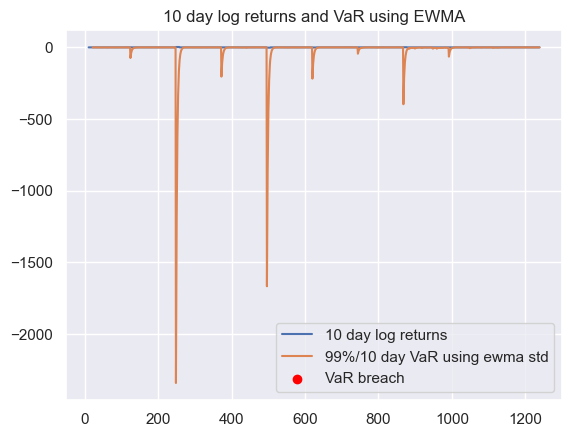

In [9]:
df['ewma_std'] = df['squared_1d_logreturns'].rolling(21).apply(ewma_product, raw=True)
df['ewma_VaR'] = -(df['ewma_std'] * 2.33 * np.sqrt(10))
df['ewma_breach'] = np.where(df['ewma_VaR'] > df['log_return_10d'], 1, 0)
df['ewma_consecutive_breach'] = np.where((df['ewma_breach'].shift(1) == 1) & (df['ewma_breach'] == 1), 1, 0)

# Report the percentage of VaR breaches
pct_breach = (len(df[df['ewma_breach'] == 1]) / len(df)) * 100
print('The number of VaR breaches using EWMA is {}. This is {} percent'.format(len(df[df['ewma_breach'] == 1]),
                                                                               pct_breach))

# Report the number of consecutive breaches
print('The number of consecutive breaches using ewma is {}'.format(df['ewma_consecutive_breach'].sum()))

# 3.B.3: Provide a plot which clearly identifies breaches
plt.plot(df['log_return_10d'], label='10 day log returns')
plt.plot(df['ewma_VaR'], label='99%/10 day VaR using ewma std')
plt.scatter(df[df['ewma_breach'] == 1].index, df[df['ewma_breach'] == 1]['log_return_10d'], color='red',
            label='VaR breach')
plt.legend()
plt.title('10 day log returns and VaR using EWMA')
plt.grid(True)
plt.savefig('3b3.png')
plt.show()